# Introduction

In this notebook, we will be focusing on **Image Conditioning** feature, which generates outputs that follow the layout and structure of a user-supplied reference image by providing it along with a text prompt. Two modes are supported:

- Canny Edge: Extract prominent edges from the reference image to guide the generation process.
- Segmentation: Define specific regions/objects within the reference image for the model to generate content aligned with those areas.

# Use Case

OctankFashion can leverage the Image Conditioning feature to automatically generate multiple variations of their ad creatives. For example, they can create different versions of a wedding dress image by adjusting the visual focus, background, or styling elements based on the reference images provided. This enables them to rapidly test and optimize their ad content, responding to customer preferences and emerging trends more effectively.


<div class="alert alert-block alert-warning">
<b>Prerequisites:</b> Please run the prerequiresites <b>00-prerequisites.ipynb</b> first before proceeding.
</div>


In [1]:
import io
import json
import base64
import boto3
from botocore.config import Config
from PIL import Image
from utils import save_image, plot_image_conditioning

bedrock_runtime_client = boto3.client(
    "bedrock-runtime",
    region_name="us-east-1",
    config=Config(
        read_timeout=5 * 60
    ),  # IMPORTANT: Increase the read timeout to 5 minutes to support longer operations.
)
image_generation_model_id = "amazon.nova-canvas-v1:0"
output_dir = "output"

### Image Conditioning

Image conditioning allows users to guide image creation using a reference image.

##### Example 1: Exploring the "SEGMENTATION" control mode

When using the `controlMode` value "SEGMENTATION", the condition image will be automatically analyzed to identify prominent content shapes. This analysis results in a segmentation mask which guides the composition of the generated image. The "SEGMENTATION" control mode allows the model more freedom than the "CANNY_EDGE" mode and is great for posing characters, establishing camera angles, and more.

We will turn the sketch below into a beautiful photo using image conditioning with the "SEGMENTATION" control mode. Run the cells below. The generated image will be saved to the "output" folder.

<img src="data/designer_sketch_dress.png" height="400">


In [2]:
# Conditioning parameters
condition_image = "data/designer_sketch_dress.png"
control_mode = "SEGMENTATION"
control_strength = 0.4  # Range: 0.2 to 1.0

prompt = "fashion photo of a woman in an elegant wedding dress, coastal backdrop"

# The output width and height should match the aspect ratio of the condition
# image for best results
width = 1024
height = 1024

seed = 102

Generating image...
Image saved to output/06-image-conditioning.png
Prompt:fashion photo of a woman in an elegant wedding dress, coastal backdrop



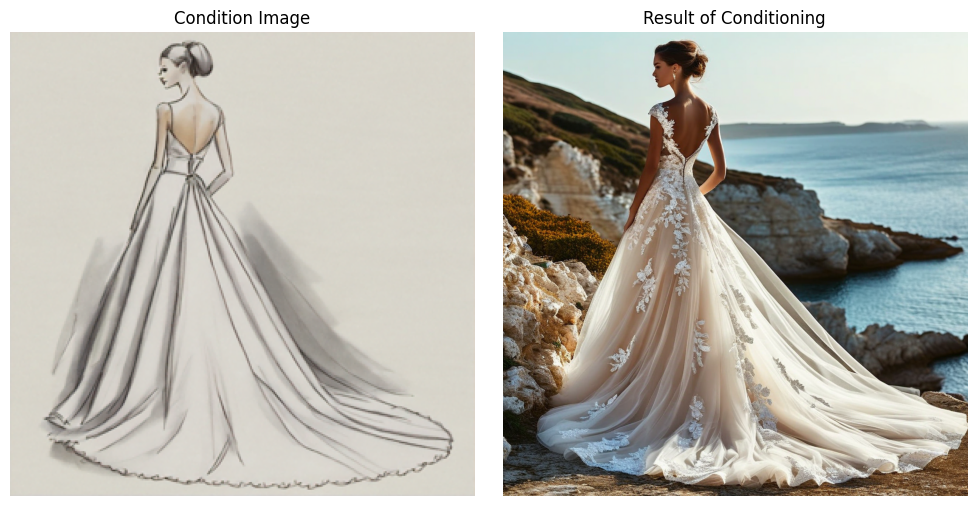

In [3]:
# Encode the reference image
with open(condition_image, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64,  # Optional
            "controlMode": control_mode,  # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": control_strength,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of images to generate, up to 5
            "width": width,
            "height": height,
            "cfgScale": 6.5,  # How closely the prompt will be followed
            "seed": seed,
            "quality": "premium",  # Quality of either "standard" or "premium"
        },
    }
)

print("Generating image...")

response = bedrock_runtime_client.invoke_model(
    body=body,
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
output_image_path = f"{output_dir}/06-image-conditioning.png"
save_image(response_body.get("images")[0], output_image_path)
print(f"Image saved to {output_image_path}")

# plot output
plot_image_conditioning(condition_image, response_images, prompt)

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Try different prompts to change environment, dress details, or art style.
</div>


##### Example 2: Exploring "CANNY_EDGE" conditioning

When using the `controlMode` value "CANNY_EDGE", elements of the generated image will follow the prominent contours, or “edges”, of the condition image. How closely these edges are respected depends on the value of the `controlStrength` parameter.

We will use the following image as the `conditionImage`. Run the cells below. The generated image will be saved to the "output" folder.

<img src="data/wedding_dress_details.png" height="400">


In [4]:
# Conditioning parameters
condition_image = "data/wedding_dress_details.png"
control_mode = "CANNY_EDGE"
control_strength = 0.9  # Range: 0 through 1.0

# The output width and height should match the aspect ratio of the condition
# image for best results
width = 720
height = 1024

prompt = "A light blue dress with elegant details"

seed = 99  # Can be any number between 0 to 214783647

Generating image...
Image saved to output/06-image-conditioning_canny-edge.png
Prompt:A light blue dress with elegant details



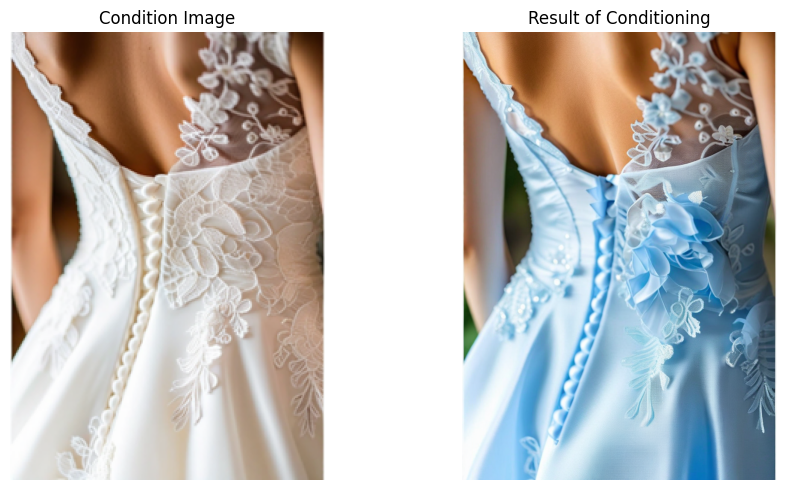

In [5]:
# Encode the reference image
with open(condition_image, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,
            "conditionImage": reference_image_base64,
            "controlMode": control_mode,  # "CANNY_EDGE" or "SEGMENTATION"
            "controlStrength": control_strength,  # Range: 0 to 1.0,
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of images to generate, up to 5
            "cfgScale": 6.5,  # How closely the prompt will be followed
            "width": width,
            "height": height,
            "seed": seed,
            "quality": "standard",  # Quality of either "standard" or "premium"
        },
    }
)

print("Generating image...")

response = bedrock_runtime_client.invoke_model(
    body=body,
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# Save output
output_image_path = f"{output_dir}/06-image-conditioning_canny-edge.png"
save_image(response_body.get("images")[0], output_image_path)
print(f"Image saved to {output_image_path}")

# Plot output
plot_image_conditioning(condition_image, response_images, prompt)

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Try different <tt>controlStrength</tt> values and different prompts to see their effect.
</div>


##### Example 3: Exploring the "controlStrength" parameter


The conditioned image generation feature allows users to tune the influence of a "condition image" on the generated output by adjusting the `controlStrength` parameter. This parameter takes values between 0.2 and 1.0, with lower values introducing more randomness and higher values resulting in generated images that more closely follow the layout and composition of the condition image. The default value for `controlStrength` parameter is 0.7


To illustrate the effect of the `controlStrength` parameter, let's generate images using the same text prompt and condition image, but with three different values.


In [6]:
# Conditioning parameters
condition_image = "data/evening_gown.png"
control_mode = "CANNY_EDGE"
control_strength_values = [0, 0.25, 1.0]  # Range: 0 through 1.0

prompt = "a women's T-shirt and short jeans showcased in a shopping window"

# The output width and height should match the aspect ratio of the condition
# image for best results
width = 1024
height = 1024

seed = 102  # 100  # Can be any random number between 0 to 214783647

Generating image 1 of 3...
Image saved to output/06-image-conditioning_controlStrength_0.png
Generating image 2 of 3...
Image saved to output/06-image-conditioning_controlStrength_0.25.png
Generating image 3 of 3...
Image saved to output/06-image-conditioning_controlStrength_1.0.png
Prompt:a women's T-shirt and short jeans showcased in a shopping window



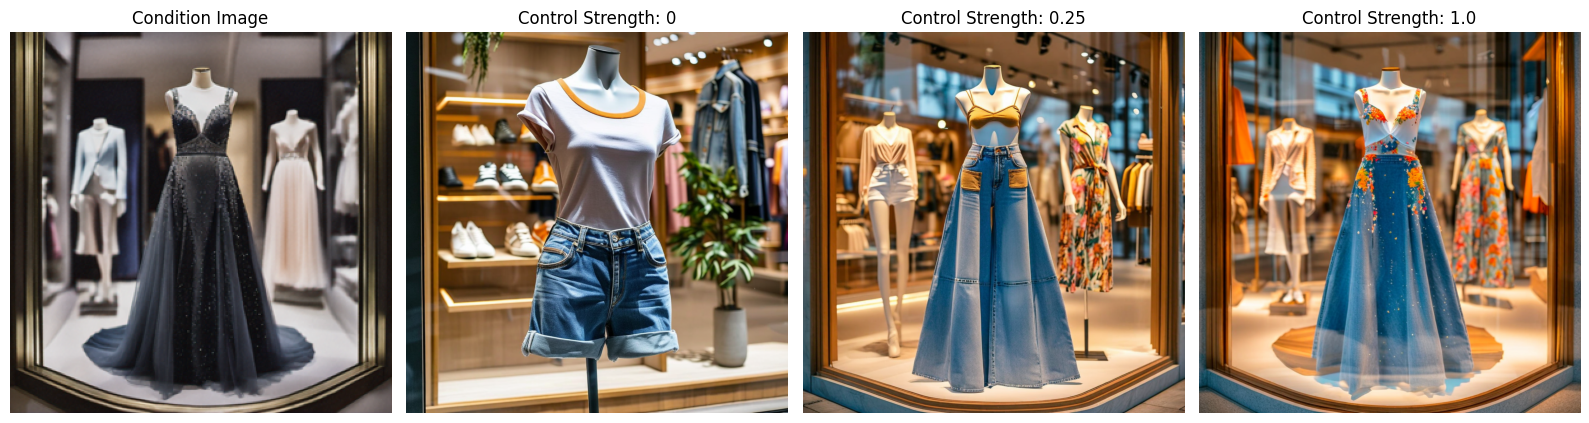

In [7]:
# Encode the reference image
with open(condition_image, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image with different similarityStrength values
generated_images = []
for index, control_strength in enumerate(control_strength_values):
    print(f"Generating image {index+1} of {len(control_strength_values)}...")

    response = bedrock_runtime_client.invoke_model(
        body=json.dumps(
            {
                "taskType": "TEXT_IMAGE",
                "textToImageParams": {
                    "text": prompt,  # Required
                    "conditionImage": reference_image_base64,  # Optional
                    "controlMode": control_mode,  # Optional: CANNY_EDGE | SEGMENTATION
                    "controlStrength": control_strength,  # Range: 0.2 to 1.0,
                },
                "imageGenerationConfig": {
                    "numberOfImages": 1,  # Number of images to generate, up to 5
                    "cfgScale": 6.5,  # How closely the prompt will be followed
                    "width": width,
                    "height": height,
                    "seed": seed,
                    "quality": "standard",  # Quality of either "standard" or "premium"
                },
            }
        ),
        modelId=image_generation_model_id,
        accept="application/json",
        contentType="application/json",
    )

    response_body = json.loads(response.get("body").read())

    # Save the image
    output_image_path = (
        f"{output_dir}/06-image-conditioning_controlStrength_{control_strength}.png"
    )
    base64_images = response_body.get("images")
    save_image(base64_images[0], output_image_path)
    print(f"Image saved to {output_image_path}")

    generated_img = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))
        for base64_image in response_body.get("images")
    ]
    generated_images.append(generated_img[0])

# plot comparison images
plot_image_conditioning(
    condition_image,
    generated_images=generated_images,
    control_strength_values=control_strength_values,
    prompt=prompt,
    comparison_mode=True,
)

Observe that when using a lower `controlStrength` value, the generated image will primarily follow the content of the text prompt, with only a subtle influence from the condition image's layout and composition. As the value increases, the condition image's influence becomes more dominant.

Users should adjust this parameter based on their desired balance between adhering to the text prompt and following the condition image's structure, considering the specific text prompt and condition image being used.


# Take Away

Image conditioning with the Nova Canvas model gives users direct control over the layout, structure, and viewing angle of their generated images.

We encourage users to explore these new functionalities within Amazon Bedrock to experience the expanded potential for creating precise, customized visual content.
